In [193]:
import numpy as np
import tensorflow as tf
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output
from sklearn.metrics import f1_score

### Initial Experiment (no modification w/ MNIST) ###

In [194]:
X,y = datasets.load_digits(return_X_y=True, as_frame=True)
X = X/255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [195]:
shape=64
ID=13

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(shape)),
    tf.keras.layers.Dense(ID, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()

model.fit(X_train, y_train, epochs=50)

clear_output(wait=True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.3207008838653564 seconds ---


In [196]:
test_loss, test_acc = model.evaluate(X_test,  y_test)
f1 = f1_score(y_test, [np.argmax(a) for a in model.predict(X_test)], average='weighted')

print('\nTest accuracy:', test_acc)
print('\nTest F1 (weighted):', f1)

12/12 [==============================] - 0s 453us/step

Test accuracy: 0.8805555701255798

Test F1 (weighted): 0.8773236425078234


### PGD Experiment (modification w/ MNIST) ###
Establish values for attack testing and training the model:

In [199]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

Load the dataset:

In [200]:
X, y = datasets.load_digits(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train /= 255.0
X_test /= 255.0

Sample information for obtaining batch sizes of the training data:

In [201]:
# batch_size = 128

# for i in range((X_train.shape[0] // batch_size)+1):
#     a = 128 * i
#     b = min(128 * (i+1), X_train.shape[0]-1)
    
#     tensor = tf.constant(X_train.iloc[a:b].astype('float32'))
#     tensor_pgd = projected_gradient_descent(model, tensor, flags_eps, 0.01, 40, np.inf)
    
#     break

Defining the model architecture and metrics:

In [239]:
shape=64
ID=13

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(shape)),
    tf.keras.layers.Dense(ID, activation='relu'),
    tf.keras.layers.Dense(10)
])

loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Metrics to track the different accuracies.
train_loss = tf.metrics.Mean(name="train_loss")
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

In [240]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

In [251]:
batch_size = 128

flags_nb_epochs = 50       # number of epochs
flags_eps = 0.3            # Total epsilon for FGM and PGD attacks
flags_adv_train = False    # Use adversarial training (on PGD adversarial examples).

# Train model with adversarial training
for epoch in range(flags_nb_epochs):
    # keras like display of progress
    progress_bar_train = tf.keras.utils.Progbar(None)
    for i in range((X_train.shape[0] // batch_size)+1):
        a = 128 * i
        b = min(128 * (i+1), X_train.shape[0]-1)
        x = tf.constant(X_train.iloc[a:b].astype('float32'))
        y = y_train[a:b]
        if flags_adv_train:
            # Replace clean example with adversarial example for adversarial training
            x = projected_gradient_descent(model, tensor, flags_eps, 0.01, 40, np.inf)
        train_step(x, y)
        progress_bar_train.add(x.shape[0], values=[("loss", train_loss.result())])

    128/Unknown - 0s 0s/step - loss: 0.179898

In [252]:
# Evaluate on clean and adversarial data
x = tf.constant(X_test.astype('float32'))
y = y_test
y_pred = model(x)
test_acc_clean(y, y_pred)

x_fgm = fast_gradient_method(model, x, flags_eps, np.inf)
y_pred_fgm = model(x_fgm)
test_acc_fgsm(y, y_pred_fgm)

x_pgd = projected_gradient_descent(model, x, flags_eps, 0.01, 40, np.inf)
y_pred_pgd = model(x_pgd)
test_acc_pgd(y, y_pred_pgd)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0069444445>

In [253]:
print(
    "test acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100)
)
print(
    "test acc on FGM adversarial examples (%): {:.3f}".format(
        test_acc_fgsm.result() * 100
    )
)
print(
    "test acc on PGD adversarial examples (%): {:.3f}".format(
        test_acc_pgd.result() * 100
    )
)

test acc on clean examples (%): 83.611
test acc on FGM adversarial examples (%): 0.972
test acc on PGD adversarial examples (%): 0.694


In [315]:
#[np.argmax(a) for a in model.predict(X_test)]
np.argmax(y_pred[0])

5

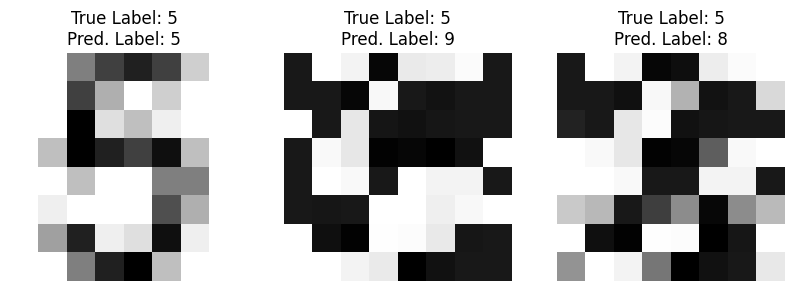

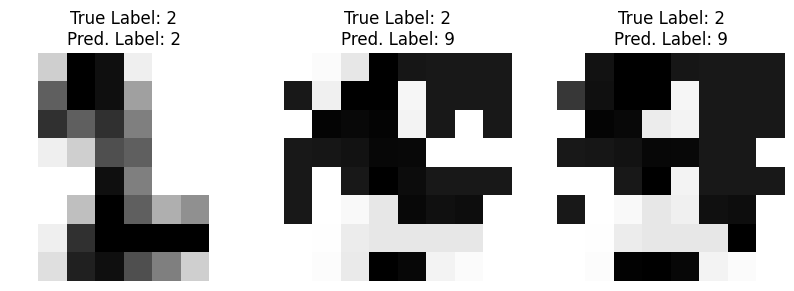

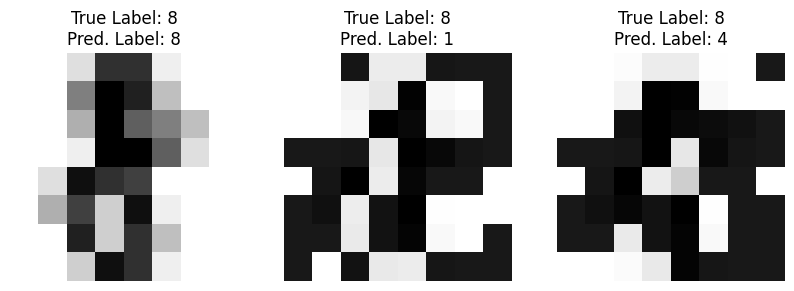

In [317]:
digits = datasets.load_digits()

for index in range(0,3):
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    for ax, image, label, pred in zip(axes, 
                                [x, x_fgm, x_pgd], 
                                np.full((3), y.iloc[index]),
                                [np.argmax(y_pred[index]), np.argmax(y_pred_fgm[index]), np.argmax(y_pred_pgd[index])]
                               ):
        image = image[index].numpy().reshape(8,8)
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("True Label: {}\nPred. Label: {}".format(label, pred))